### Spaceship Titanic with fastai

Competition [Link](https://www.kaggle.com/competitions/spaceship-titanic/overview)

In [1]:
#|default_exp app

In [2]:
#The Following cell of code is used everytime FASTAI library is used.
#They tell the notebook to reload any changes made to any libraries used.
#They also ensure that any graphs are plotted are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [3]:
from fastai.tabular.all import *
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import dtreeviz

### Import Datasets and Create Dataframe

In [4]:
#| export
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = ''

In [5]:
#| export
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
#| export
path = Path('spaceship-titanic')

In [7]:
#| export
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))    
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [8]:
#| export
if iskaggle:
    path = Path('../input/spaceship-titanic')
    ! pip install -q dataset

Import CSV's as Pandas Dataframes

In [9]:
#| export
df = pd.read_csv(path/'train.csv', low_memory=False)
test_df = pd.read_csv(path/'test.csv', low_memory=False)
sample_df = pd.read_csv(path/'sample_submission.csv', low_memory=False)

In [10]:
df.head(n=15)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


Looking at this there's some extra data we can extract to new columns, *PassengerId* looks like it's by group number and the number in a particular group, split with an underscore `_` 

In [11]:
df['PassengerId'].value_counts

<bound method IndexOpsMixin.value_counts of 0       0001_01
1       0002_01
2       0003_01
3       0003_02
4       0004_01
         ...   
8688    9276_01
8689    9278_01
8690    9279_01
8691    9280_01
8692    9280_02
Name: PassengerId, Length: 8693, dtype: object>

In [12]:
df['group_num'] = df['PassengerId'].str.split('_').str[0]
df['group_size'] = df['PassengerId'].str.split('_').str[1]

The same is true for the Cabin, there are 3 different values to analyze here, so let's split them up as well

In [13]:
df['deck'] = df['Cabin'].str.split('/').str[0]
df['room_num'] = df['Cabin'].str.split('/').str[1]
df['side'] = df['Cabin'].str.split('/').str[2]

In [14]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_size,deck,room_num,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,F,1,S


In [15]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
group_num         0
group_size        0
deck            199
room_num        199
side            199
dtype: int64

In [16]:
def get_null_counts(df):
    null_count_df = pd.DataFrame((df.isnull().sum()).sort_values(ascending=False).reset_index())
    null_count_df.columns = ['column_name','null_counts']
    null_count_df = null_count_df.query("column_name!='Transported'")
    return null_count_df

null_= get_null_counts(df)
null_.style.background_gradient(cmap='hot')

,column_name,null_counts
0,CryoSleep,217
1,ShoppingMall,208
2,VIP,203
3,HomePlanet,201
4,Name,200
5,room_num,199
6,deck,199
7,side,199
8,Cabin,199
9,VRDeck,188


In [17]:
df['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Add a function to convert boolean values to 0 and 1 using `LabelEncoder` 

In [18]:
def bool_switch(df, col_name):
    encoder = LabelEncoder()
    df[f'{col_name}'] = encoder.fit_transform(df[f'{col_name}']) 

In [19]:
bool_switch(df, col_name='Transported')
bool_switch(df, col_name='VIP')
bool_switch(df, col_name='CryoSleep')


Check to see how it worked

In [20]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_size,deck,room_num,side
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0001,01,B,0,P
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,0002,01,F,0,S
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0003,01,A,0,S
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0003,02,A,0,S
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,0004,01,F,1,S


In [21]:
df['Transported'].value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8693 non-null   int64  
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8693 non-null   int64  
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
 14  group_num     8693 non-null   object 
 15  group_size    8693 non-null   object 
 16  deck          8494 non-null   object 
 17  room_num      8494 non-null   object 
 18  side          8494 non-null 

In [23]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'group_num', 'group_size', 'deck', 'room_num',
       'side'],
      dtype='object')

### Preparing Data

Declare dependant variable(y-axis)

In [24]:
#| export
dep_var = 'Transported'

In [25]:
df['Destination'].sample

<bound method NDFrame.sample of 0         TRAPPIST-1e
1         TRAPPIST-1e
2         TRAPPIST-1e
3         TRAPPIST-1e
4         TRAPPIST-1e
            ...      
8688      55 Cancri e
8689    PSO J318.5-22
8690      TRAPPIST-1e
8691      55 Cancri e
8692      TRAPPIST-1e
Name: Destination, Length: 8693, dtype: object>

Add tabular processes to transform categorical variables to something similar to `pd.Categorical`, and fill in missing/na values

In [26]:
#| export
procs = [Categorify, FillMissing, Normalize]

Split our data set into a training(.8) and a validation(.2) set, set random_state to a fixed seed for consistency

In [27]:
#| export
train, valid = train_test_split(df, test_size=.2, random_state=42)

Check the sizes of the split

In [28]:
len(train), len(valid)

(6954, 1739)

Get an array of indexes for the training and validation sets

In [29]:
#| export
train_idx = np.array(train.index)
valid_idx = np.array(valid.index)
train_idx, valid_idx

(array([2333, 2589, 8302, ..., 5390,  860, 7270]),
 array([ 304, 2697, 8424, ..., 1302, 5934, 6093]))

Double check no duplicates

In [30]:
u, c = np.unique(valid_idx, return_counts=True)
dup = u[c > 1]
dup

array([], dtype=int64)

Pass `splits` a tuple of lists containing the training and validation indexes

In [31]:
#| export
splits = (list(train_idx), list(valid_idx))

Use `cont_cat_split` to separate continuous and categorical variables

In [32]:
#| export
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

Load our dataframe to a `TabularPandas` object, `procs` from above is applied here. Set the dependant variable as the target

In [33]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [34]:
len(to.train), len(to.valid)

(6954, 1739)

In [35]:
df['Transported'].sum()

4378

In [36]:
len(df)

8693

Pickle our tabular object so that we can skip a few steps in the future

In [37]:
save_pickle(path/'space_titan_to.pkl', to)

Load our Pickle file

In [38]:
to = load_pickle(path/'space_titan_to.pkl')

In [39]:
to.items['PassengerId']

2333    2334
2589    2590
8302    8303
8177    8178
500      501
        ... 
7175    7176
3187    3188
1302    1303
5934    5935
6093    6094
Name: PassengerId, Length: 8693, dtype: int16

In [40]:
to.items.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_size,deck,room_num,side,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na
2333,2334,1,-0.735289,0,3,-0.055214,-0.207316,-0.326853,-0.251604,-0.282179,0.312621,-0.256843,5072,0,1678,1,0,0,0,1,1,1,1,1,1
2589,2590,1,-0.735289,3953,3,-0.824809,-0.207316,-0.326853,0.479133,-0.231124,-0.279427,-0.256843,2014,0,1863,2,6,1349,1,1,1,1,1,1,1
8302,8303,2,1.121356,933,1,-0.055214,-0.207316,-0.326853,-0.286859,-0.282179,-0.279427,-0.256843,427,1,5945,4,3,1076,2,1,1,1,1,1,1
8177,8178,3,-0.735289,3334,3,-0.614920,-0.207316,-0.326853,-0.285577,0.193788,0.601424,-0.256843,7876,1,5858,2,6,849,1,1,2,1,1,1,1
500,501,2,1.121356,720,1,0.504492,-0.207316,-0.326853,-0.286859,-0.282179,-0.279427,-0.256843,37,1,359,2,3,847,1,1,1,1,1,1,1


In [41]:
to.train.xs

,PassengerId,HomePlanet,Cabin,Destination,Name,group_num,group_size,deck,room_num,side,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
2333,2334,1,0,3,5072,1678,1,0,0,0,1,1,1,1,1,1,-0.735289,-0.055214,-0.207316,-0.326853,-0.251604,-0.282179,0.312621,-0.256843
2589,2590,1,3953,3,2014,1863,2,6,1349,1,1,1,1,1,1,1,-0.735289,-0.824809,-0.207316,-0.326853,0.479133,-0.231124,-0.279427,-0.256843
8302,8303,2,933,1,427,5945,4,3,1076,2,1,1,1,1,1,1,1.121356,-0.055214,-0.207316,-0.326853,-0.286859,-0.282179,-0.279427,-0.256843
8177,8178,3,3334,3,7876,5858,2,6,849,1,1,2,1,1,1,1,-0.735289,-0.614920,-0.207316,-0.326853,-0.285577,0.193788,0.601424,-0.256843
500,501,2,720,1,37,359,2,3,847,1,1,1,1,1,1,1,1.121356,0.504492,-0.207316,-0.326853,-0.286859,-0.282179,-0.279427,-0.256843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,5735,1,6540,3,7676,4107,1,7,1805,2,1,1,1,1,1,1,2.978000,-0.754846,-0.207316,-0.305938,-0.285577,-0.045019,0.271105,-0.256843
5191,5192,3,2280,3,3858,3729,1,6,73,2,1,1,1,1,1,1,-0.735289,1.483976,5.799678,0.703968,-0.286859,-0.232771,0.408287,0.112561
5390,5391,1,2473,2,4569,3875,6,6,215,1,1,1,1,1,1,1,-0.735289,-0.474993,-0.207316,-0.090810,-0.286859,0.501767,-0.279427,-0.234403
860,861,3,3411,3,7121,615,1,6,923,1,1,1,1,1,1,1,-0.735289,0.364565,-0.207316,0.239351,-0.286859,2.395754,-0.279427,-0.256843


Assign our X values and Y value for training and validation

In [42]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

/tmp/ipykernel_1241/3888966817.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<AxesSubplot: >

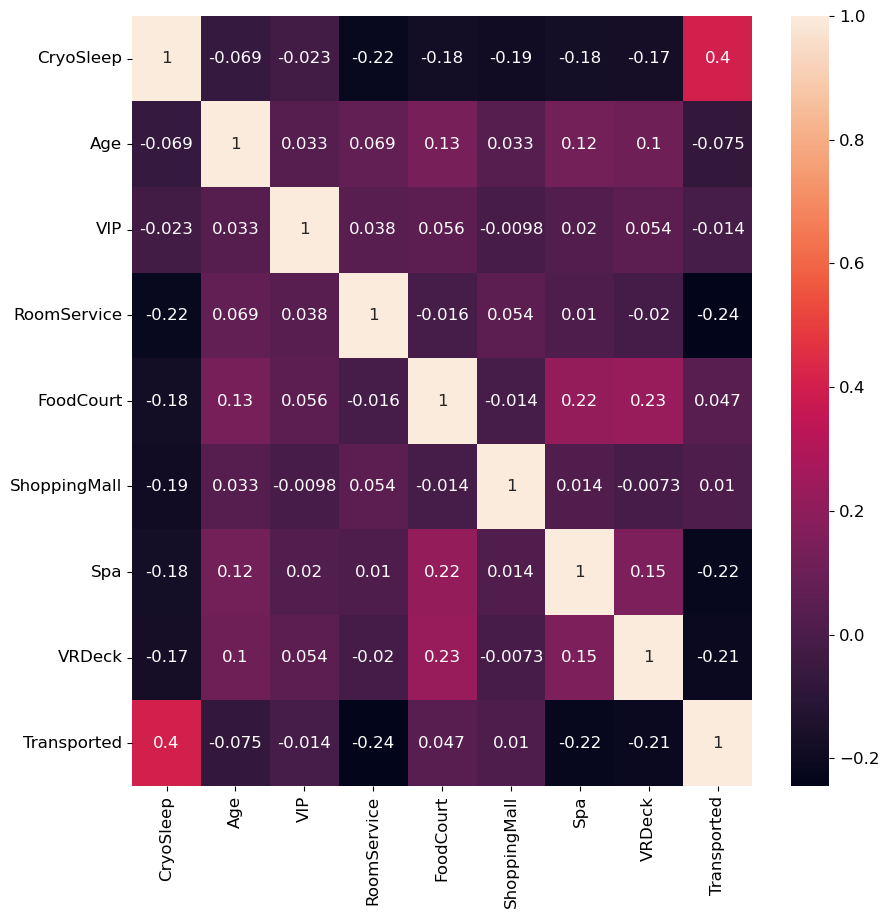

In [43]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

### Decision Tree Classifier

Test a small tree with 4 leaf nodes

In [44]:
m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(xs, y);

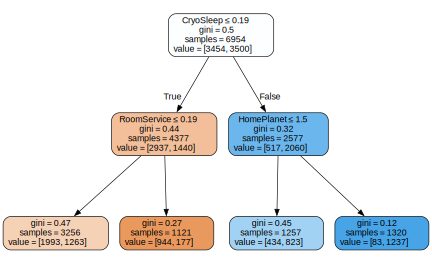

In [45]:
draw_tree(m, xs, size=6, leaves_parallel=True, precision=2)

Have the model run predictions on the validation set for who would be transported

In [46]:
y_pred = m.predict(valid_xs)

In [47]:
y_pred

array([0, 0, 1, ..., 0, 1, 0], dtype=int8)

Check how accurate our predictions were against the actual validation data

In [48]:
accuracy = accuracy_score(valid_y, y_pred)
accuracy

0.714203565267395

In [49]:
samp_idx = np.random.permutation(len(y))[:500]

In [50]:
viz_model = dtreeviz.model(m, X_train=xs.iloc[samp_idx], y_train=y.iloc[samp_idx], target_name=dep_var)

/home/petewin/mambaforge/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


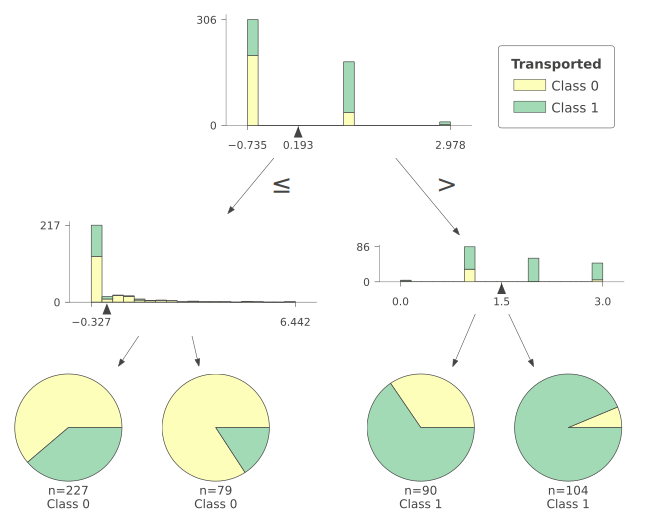

In [51]:
viz_model.view(fontname="DejaVu Sans", scale=1.8, label_fontsize=10)

In [54]:
viz_model = dtreeviz.model(m, X_train=xs, y_train=y, target_name=dep_var)

/home/petewin/mambaforge/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


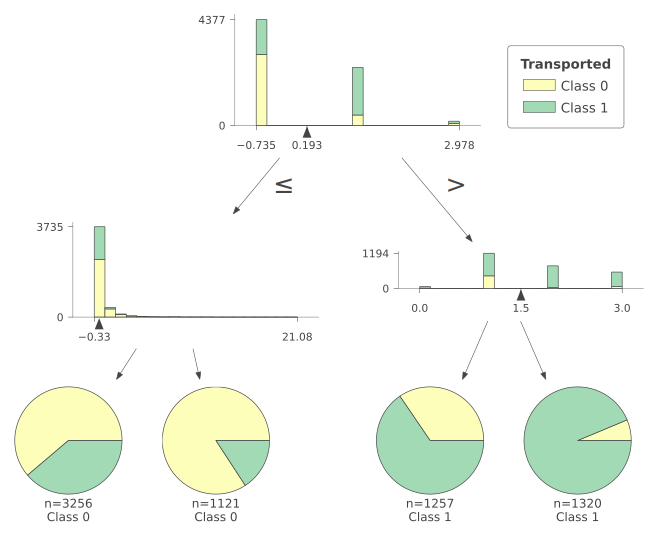

In [55]:
viz_model.view(fontname="DejaVu Sans", scale=1.8, label_fontsize=10)

### Logistic Regression

Run the same test with a quick logistic regression model

In [57]:
m = LogisticRegression(max_iter=1000)
m.fit(xs, y);

In [58]:
y_pred = m.predict(valid_xs)

In [59]:
accuracy = accuracy_score(valid_y, y_pred)
accuracy

0.7705577918343876

### All Leaves Decision Tree 

Run the same decision tree model, let it max out the leaves until there is one for each

In [60]:
m = DecisionTreeClassifier()
m.fit(xs, y);

In [61]:
y_pred = m.predict(valid_xs)

In [62]:
accuracy = accuracy_score(valid_y, y_pred)
accuracy

0.7280046003450259

In [63]:
m.get_n_leaves(), len(xs)

(1058, 6954)

### 25 Leaves Decision Tree 

Scale back to 25 Leaves as a happy medium

In [64]:
m = DecisionTreeClassifier(min_samples_leaf=25)
m.fit(xs, y);

In [65]:
y_pred = m.predict(valid_xs)

In [66]:
accuracy = accuracy_score(valid_y, y_pred)
accuracy

0.765382403680276

### Random Forest

Create a function to make it easier to try several variations in succession

In [67]:
def rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_features=max_features, min_samples_leaf=min_samples_leaf, 
        oob_score=True).fit(xs,y)

In [68]:
m = rf(xs,y)

In [69]:
def pred_acc(m):
    y_pred = m.predict(valid_xs)
    accuracy = accuracy_score(valid_y, y_pred)
    return accuracy
    

In [70]:
pred_acc(m)

0.7918343875790684

In [71]:
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])

In [72]:
m.oob_score_

0.8002588438308887

In [73]:
valid_y.values

array([1, 0, 0, ..., 0, 1, 0], dtype=int8)